# Gradient boosting Optimization
In this notebook, more data pertaining to components 1-3 is added.

In [3]:
%matplotlib inline
import os, glob
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
from IPython.display import display
#from pyearth import Earth

In [4]:
traintest = pd.read_csv(os.path.join('..','competition_data','traintest.csv'),header=0)
traintest1 = traintest.loc[:,[u'supplier', u'year','month','day', u'annual_usage',
       'min_order_quantity', u'bracket_pricing', u'quantity', 
       'material_id', u'diameter', u'wall', u'length', u'num_bends',
       'bend_radius', u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x',
       'end_a', u'end_x', 'num_boss', u'num_bracket', 
       u'other',
       'part_name_1','part_name_2','part_name_3', 
       'component_type_id_1','component_type_id_2','component_type_id_3',
       'quantity_1','quantity_2','quantity_3',
       'connection_type_id_2',
       'end_form_id_1_1','end_form_id_2_1',
       'hex_nut_size_1','hex_size_1','hex_size_3',
       'intended_nut_thread_1','length_1','length_2',
       'thread_pitch_1','thread_size_1_1','thread_size_1_3',
       'orientation_1','orientation_2','orientation_3',
       'overall_length_1',#'plating_2',
       'cost']]

In [5]:
traintest1['part_name_1'] = traintest1.part_name_1.fillna('NONE')
traintest1['part_name_2'] = traintest1.part_name_2.fillna('NONE')
traintest1['part_name_3'] = traintest1.part_name_3.fillna('NONE')
traintest1['component_type_id_1'] = traintest1.component_type_id_1.fillna('NONE')
traintest1['component_type_id_2'] = traintest1.component_type_id_2.fillna('NONE')
traintest1['component_type_id_3'] = traintest1.component_type_id_3.fillna('NONE')
traintest1['quantity_1'] = traintest1.quantity_1.fillna(0)
traintest1['quantity_2'] = traintest1.quantity_2.fillna(0)
traintest1['quantity_3'] = traintest1.quantity_3.fillna(0)
traintest1['connection_type_id_2'] = traintest1.connection_type_id_2.fillna('NONE')
traintest1['end_form_id_1_1'] = traintest1.end_form_id_1_1.fillna('NONE')
traintest1['end_form_id_2_1'] = traintest1.end_form_id_2_1.fillna('NONE')
traintest1['hex_nut_size_1'] = traintest1.hex_nut_size_1.fillna(0)
traintest1['hex_size_1'] = traintest1.hex_size_1.fillna(0)
traintest1['hex_size_3'] = traintest1.hex_size_3.fillna(0)
traintest1['intended_nut_thread_1'] = traintest1.intended_nut_thread_1.fillna(0)#
traintest1['length_1'] = traintest1.length_1.fillna(0)
traintest1['length_2'] = traintest1.length_2.fillna(0)
traintest1['thread_pitch_1'] = traintest1.thread_pitch_1.fillna(0) # 
traintest1['thread_size_1_1'] = traintest1.thread_size_1_1.fillna(0)#
traintest1['thread_size_1_3'] = traintest1.thread_size_1_3.fillna(0)#
traintest1['orientation_1'] = traintest1.orientation_1.fillna('No')#
traintest1['orientation_2'] = traintest1.orientation_2.fillna("No")#
traintest1['orientation_3'] = traintest1.orientation_3.fillna("No")#
traintest1['overall_length_1'] = traintest1.overall_length_1.fillna(0)

In [29]:
traintest1.connection_type_id_2.value_counts()

ORFS-SAE J1453           27828
NONE                     25686
37 deg Flare-SAE J514     6737
SAE STOR-SAE J1926         127
NPTF-SAE J476/J514          42
Code 61 Flange              17
Other                        6
Metric STOR-ISO 6149         5
dtype: int64

In [30]:
class PruneLabelEncoder(LabelEncoder):
    def __init___(self):
        super(PruneLabelEncoder, self).__init__()
    def fit(self, series, cutoff=10):
        self.cutoff = cutoff
        # Generate the transformation classes and also the map for low output munging 
        super(PruneLabelEncoder, self).fit(series)
        trans_series = super(PruneLabelEncoder, self).transform(series)
        self.val_count_map = defaultdict(int)
        for i in trans_series:
            self.val_count_map[i] += 1
        # identify the first key with low frequency and use it for all low freq vals
        for key, val in self.val_count_map.items():
            if val < self.cutoff:
                self.low_cnt_target = key
                break
    def transform(self, series):
        trans_series = super(PruneLabelEncoder, self).transform(series)
        # Transform all the low frequency keys into the low frequency target key
        for key, val in self.val_count_map.items():
            if val < self.cutoff:
                trans_series[trans_series==key] = self.low_cnt_target
        return trans_series

In [31]:
TRANSFORM_CUTOFF = 25

In [32]:
enc_comp_typeid = PruneLabelEncoder()
comp_id1 = traintest1.component_type_id_1.values
comp_id2 = traintest1.component_type_id_2.values
comp_id3 = traintest1.component_type_id_3.values
comp_id = np.concatenate((comp_id1, comp_id2, comp_id3))
enc_comp_typeid.fit(comp_id, cutoff=TRANSFORM_CUTOFF)  

enc_end_form_id = PruneLabelEncoder()
end_form_id1 = traintest1.end_form_id_1_1.values
end_form_id2 = traintest1.end_form_id_2_1.values
end_form_id = np.concatenate((end_form_id1,end_form_id2))
enc_end_form_id.fit(end_form_id, cutoff=TRANSFORM_CUTOFF)  

enc_connection_type_id = PruneLabelEncoder()
enc_connection_type_id.fit(traintest1.connection_type_id_2.values)

enc_mat_id = PruneLabelEncoder()
enc_mat_id.fit(traintest1.material_id.values, cutoff=TRANSFORM_CUTOFF)  
enc_splr_id = PruneLabelEncoder()
enc_splr_id.fit(traintest1.supplier.values, cutoff=TRANSFORM_CUTOFF)

enda_vals = traintest1.end_a.values
endx_vals = traintest1.end_x.values
end_vals = np.concatenate((enda_vals, endx_vals))
enc_end = PruneLabelEncoder()
enc_end.fit(end_vals, cutoff=TRANSFORM_CUTOFF) 

/Users/mbkumar/venv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Users/mbkumar/venv2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:251: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [33]:
train = traintest1.loc[0:30212]
test = traintest1.loc[30213:]

## Categorical variables pruning
The categorical variables such as supplier_id, material_id, component_id_x_name, 
end_x, end_a with string categories are converted to integer
labels. The values with high frequencies are retained and the low
frequency values (<50) are all combined into a single value

num_boss, num_brack and other have one or two high frequency values and then few low frequency values

In the predictor 'comp_id_x' related data where x = 4,5,6,7,8 is unncessary since the non null data is < 2.6%
In addition tube_assembly id is removed from now on.

In [34]:
comp_id1_trans = enc_comp_typeid.transform(train.component_type_id_1.values)
comp_id2_trans = enc_comp_typeid.transform(train.component_type_id_2.values)
comp_id3_trans = enc_comp_typeid.transform(train.component_type_id_3.values)
matid_trans = enc_mat_id.transform(train.material_id.values)
splr_trans = enc_splr_id.transform(train.supplier.values)
end_a_trans = enc_end.transform(train.end_a.values)
end_x_trans = enc_end.transform(train.end_x.values)
end_form_id1_trans = enc_end_form_id.transform(train.end_form_id_1_1.values)
end_form_id2_trans = enc_end_form_id.transform(train.end_form_id_2_1.values)
conn_type_id_trans = enc_connection_type_id.transform(train.connection_type_id_2.values)

end_x_1x_vals = [1 if x=='Y' else 0 for x in train.end_x_1x.values]
end_a_1x_vals = [1 if x=='Y' else 0 for x in train.end_a_1x.values]
end_x_2x_vals = [1 if x=='Y' else 0 for x in train.end_x_2x.values]
end_a_2x_vals = [1 if x=='Y' else 0 for x in train.end_a_2x.values]
brack_price_vals = [1 if x=='Yes' else 0 for x in train.bracket_pricing.values]
orient_1_vals = [1 if x=='Yes' else 0 for x in train.orientation_1.values]
orient_2_vals = [1 if x=='Yes' else 0 for x in train.orientation_2.values]
orient_3_vals = [1 if x=='Yes' else 0 for x in train.orientation_3.values]

The first four material ids have high frequencies. Its better to assign those 4 to 
different values and group the rest into a single value

In [35]:
trainp1 = train.loc[:,[#u'supplier', 
       'year','month','day', u'annual_usage',
       'min_order_quantity', #u'bracket_pricing',
       'quantity', 
       #'material_id', 
       'diameter', u'wall', u'length', u'num_bends',
       'bend_radius',
       #'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x','end_a', u'end_x',
       'num_boss', u'num_bracket', u'other',
       ##'part_name_1','part_name_2','part_name_3', 
       #'component_type_id_1','component_type_id_2','component_type_id_3',
       'quantity_1','quantity_2','quantity_3',
       #'connection_type_id_2',
       #'end_form_id_1_1','end_form_id_2_1',
       'hex_nut_size_1','hex_size_1','hex_size_3',
       'intended_nut_thread_1','length_1','length_2',
       'thread_pitch_1','thread_size_1_1','thread_size_1_3',
       #'orientation_1','orientation_2','orientation_3',
       'overall_length_1',
       'cost']]
# Reencode the categorical variables
trainp1.insert(0, 'supplier', splr_trans, allow_duplicates=False)
trainp1.insert(6, 'bracket_pricing', brack_price_vals, allow_duplicates=False)
trainp1.insert(8, 'material_id', matid_trans, allow_duplicates=False)
trainp1.insert(14, 'end_a_1x', end_a_1x_vals, allow_duplicates=False)
trainp1.insert(15, 'end_a_2x', end_a_2x_vals, allow_duplicates=False)
trainp1.insert(16, 'end_x_1x', end_x_1x_vals, allow_duplicates=False)
trainp1.insert(17, 'end_x_2x', end_x_2x_vals, allow_duplicates=False)
trainp1.insert(18, 'end_a', end_a_trans, allow_duplicates=False)
trainp1.insert(19, 'end_x', end_x_trans, allow_duplicates=False)
trainp1.insert(23, 'component_type_id_1', comp_id1_trans, allow_duplicates=False)
trainp1.insert(24, 'component_type_id_2', comp_id2_trans, allow_duplicates=False)
trainp1.insert(25, 'component_type_id_3', comp_id3_trans, allow_duplicates=False)
#trainp1.insert(26, 'quantity_1', quant1, allow_duplicates=False)
#trainp1.insert(27, 'quantity_2', quant2, allow_duplicates=False)
#trainp1.insert(28, 'quantity_3', quant3, allow_duplicates=False)
trainp1.insert(29, 'connection_type_id_2', conn_type_id_trans, allow_duplicates=False)
trainp1.insert(30, 'end_form_id_1_1', end_form_id1_trans, allow_duplicates=False)
trainp1.insert(31, 'end_form_id_2_1', end_form_id2_trans, allow_duplicates=False)
trainp1.insert(41, 'orientation_1', orient_1_vals, allow_duplicates=False)
trainp1.insert(42, 'orientation_2', orient_2_vals, allow_duplicates=False)
trainp1.insert(43, 'orientation_3', orient_3_vals, allow_duplicates=False)
trainp1 = trainp1.drop('end_a_1x',1)
trainp1 = trainp1.drop('component_type_id_1',1)
trainp1 = trainp1.drop('component_type_id_2',1)
trainp1 = trainp1.drop('component_type_id_3',1)
trainp1 = trainp1.drop('num_bracket',1)
trainp1 = trainp1.drop('intended_nut_thread_1',1)
trainp1 = trainp1.drop('thread_pitch_1',1)
trainp1 = trainp1.drop('thread_size_1_1',1)
trainp1 = trainp1.drop('thread_size_1_3',1)
trainp1 = trainp1.drop('orientation_1',1)
trainp1 = trainp1.drop('orientation_2',1)
trainp1 = trainp1.drop('orientation_3',1)
#trainp1.columns

Index([            u'supplier',                 u'year',
                      u'month',                  u'day',
               u'annual_usage',   u'min_order_quantity',
            u'bracket_pricing',             u'quantity',
                u'material_id',             u'diameter',
                       u'wall',               u'length',
                  u'num_bends',          u'bend_radius',
                   u'end_a_2x',             u'end_x_1x',
                   u'end_x_2x',                u'end_a',
                      u'end_x',             u'num_boss',
                      u'other',           u'quantity_1',
                 u'quantity_2',           u'quantity_3',
       u'connection_type_id_2',      u'end_form_id_1_1',
            u'end_form_id_2_1',       u'hex_nut_size_1',
                 u'hex_size_1',           u'hex_size_3',
                   u'length_1',             u'length_2',
           u'overall_length_1',                 u'cost'],
      dtype='object')

In [37]:
X_cols = trainp1.columns[:-1]

Index([            u'supplier',                 u'year',
                      u'month',                  u'day',
               u'annual_usage',   u'min_order_quantity',
            u'bracket_pricing',             u'quantity',
                u'material_id',             u'diameter',
                       u'wall',               u'length',
                  u'num_bends',          u'bend_radius',
                   u'end_a_2x',             u'end_x_1x',
                   u'end_x_2x',                u'end_a',
                      u'end_x',             u'num_boss',
                      u'other',           u'quantity_1',
                 u'quantity_2',           u'quantity_3',
       u'connection_type_id_2',      u'end_form_id_1_1',
            u'end_form_id_2_1',       u'hex_nut_size_1',
                 u'hex_size_1',           u'hex_size_3',
                   u'length_1',             u'length_2',
           u'overall_length_1'],
      dtype='object')
30213


In [38]:
for col in trainp1.columns:
    no_null = np.sum(trainp1[col].isnull().values)
    if no_null:
        print col, no_null

# Randomize the data

In [39]:
train_shfl = trainp1.iloc[np.random.permutation(len(trainp1))]

In [40]:
X = train_shfl.as_matrix(train_shfl.columns[:-1])
y = train_shfl.as_matrix(['cost'])[:,0]
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

In [ ]:
###############################################################################
# Fit regression model
params = {'n_estimators': 4000, 'max_depth': 10, 'min_samples_split': 6,
          'learning_rate': 0.01, 'loss': 'lad', 'subsample': 0.7}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.xlim( 0, 2000 )
plt.ylabel('Deviance')

plt.show()

In [23]:
def rmsle_fn(y_true, y_pred):
    from math import log, sqrt
    assert len(y_true) == len(y_pred)
    # Convert all negative y_pred to zero
    y_pred[y_pred < 0] = 0
    rmsle = 0
    for pair in zip(y_true, y_pred):
        log_diff = log(1+pair[1]) - log(1+pair[0]) 
        rmsle += log_diff*log_diff
    rmsle = sqrt(rmsle/len(y_true))
    return rmsle
rmsle_loss = make_scorer(rmsle_fn, greater_is_better=False)

In [30]:
params = {'n_estimators': 4000, 'max_depth': 10, 'min_samples_split': 6,
          'learning_rate': 0.01, 'loss': 'lad', 'subsample': 0.7}
gbr_opt = GradientBoostingRegressor(**params)

In [33]:
scores = cross_validation.cross_val_score(gbr_opt, X, y, scoring=rmsle_loss, cv=5)
print("Loss: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

Loss: -0.22 (+/- 0.03)


array([-0.21623896, -0.24367865, -0.21750908, -0.20910417, -0.23312248])

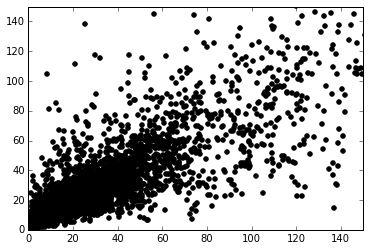

In [157]:
pred_y = cross_validation.cross_val_predict(gbr_opt,X,y, cv=6, n_jobs=-1)
#pred_y = cross_validation.cross_val_predict?
plt.scatter(y, pred_y,  color='black')
plt.xlim((0,150))
plt.ylim ((0,150))

plt.show()

In [33]:
gbr_opt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=4000,
             random_state=None, subsample=0.7, verbose=0, warm_start=False)

In [34]:
gbr_opt.feature_importances_

array([ 0.03667832,  0.01207276,  0.04080456,  0.10252236,  0.09597256,
        0.05253317,  0.00610604,  0.13503141,  0.02350828,  0.03257298,
        0.03037077,  0.13542004,  0.04832166,  0.03553777,  0.00863711,
        0.00404457,  0.00728959,  0.01115421,  0.01050346,  0.00508049,
        0.00475655,  0.01267434,  0.01026237,  0.00997013,  0.00582991,
        0.00471879,  0.0060301 ,  0.01161321,  0.00753043,  0.00936785,
        0.00614569,  0.01574644,  0.01410686,  0.01016464,  0.00521114,
        0.00913066,  0.00553644,  0.01704233])

In [36]:
comp_id1_trans = enc_comp_typeid.transform(test.component_type_id_1.values)
comp_id2_trans = enc_comp_typeid.transform(test.component_type_id_2.values)
comp_id3_trans = enc_comp_typeid.transform(test.component_type_id_3.values)
matid_trans = enc_mat_id.transform(test.material_id.values)
splr_trans = enc_splr_id.transform(test.supplier.values)
end_a_trans = enc_end.transform(test.end_a.values)
end_x_trans = enc_end.transform(test.end_x.values)
end_form_id1_trans = enc_end_form_id.transform(test.end_form_id_1_1.values)
end_form_id2_trans = enc_end_form_id.transform(test.end_form_id_2_1.values)
conn_type_id_trans = enc_connection_type_id.transform(test.connection_type_id_2.values)

end_x_1x_vals = [1 if x=='Y' else 0 for x in test.end_x_1x.values]
end_a_1x_vals = [1 if x=='Y' else 0 for x in test.end_a_1x.values]
end_x_2x_vals = [1 if x=='Y' else 0 for x in test.end_x_2x.values]
end_a_2x_vals = [1 if x=='Y' else 0 for x in test.end_a_2x.values]
brack_price_vals = [1 if x=='Yes' else 0 for x in test.bracket_pricing.values]
orient_1_vals = [1 if x=='Yes' else 0 for x in test.orientation_1.values]
orient_2_vals = [1 if x=='Yes' else 0 for x in test.orientation_2.values]
orient_3_vals = [1 if x=='Yes' else 0 for x in test.orientation_3.values]

In [37]:
testp = test.loc[:,[#u'supplier', 
       'year','month','day', u'annual_usage',
       'min_order_quantity', #u'bracket_pricing',
       'quantity', 
       #'material_id', 
       'diameter', u'wall', u'length', u'num_bends',
       'bend_radius',
       #'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x','end_a', u'end_x',
       'num_boss', u'num_bracket', u'other',
       ##'part_name_1','part_name_2','part_name_3', 
       #'component_type_id_1','component_type_id_2','component_type_id_3',
       'quantity_1','quantity_2','quantity_3',
       #'connection_type_id_2',
       #'end_form_id_1_1','end_form_id_2_1',
       'hex_nut_size_1','hex_size_1','hex_size_3',
       'intended_nut_thread_1','length_1','length_2',
       'thread_pitch_1','thread_size_1_1','thread_size_1_3',
       #'orientation_1','orientation_2','orientation_3',
       'overall_length_1'
       ]]
# Reencode the categorical variables
testp.insert(0, 'supplier', splr_trans, allow_duplicates=False)
testp.insert(6, 'bracket_pricing', brack_price_vals, allow_duplicates=False)
testp.insert(8, 'material_id', matid_trans, allow_duplicates=False)
testp.insert(14, 'end_a_1x', end_a_1x_vals, allow_duplicates=False)
testp.insert(15, 'end_a_2x', end_a_2x_vals, allow_duplicates=False)
testp.insert(16, 'end_x_1x', end_x_1x_vals, allow_duplicates=False)
testp.insert(17, 'end_x_2x', end_x_2x_vals, allow_duplicates=False)
testp.insert(18, 'end_a', end_a_trans, allow_duplicates=False)
testp.insert(19, 'end_x', end_x_trans, allow_duplicates=False)
testp.insert(23, 'component_type_id_1', comp_id1_trans, allow_duplicates=False)
testp.insert(24, 'component_type_id_2', comp_id2_trans, allow_duplicates=False)
testp.insert(25, 'component_type_id_3', comp_id3_trans, allow_duplicates=False)
testp.insert(29, 'connection_type_id_2', conn_type_id_trans, allow_duplicates=False)
testp.insert(30, 'end_form_id_1_1', end_form_id1_trans, allow_duplicates=False)
testp.insert(31, 'end_form_id_2_1', end_form_id2_trans, allow_duplicates=False)
testp.insert(41, 'orientation_1', orient_1_vals, allow_duplicates=False)
testp.insert(42, 'orientation_2', orient_2_vals, allow_duplicates=False)
testp.insert(43, 'orientation_3', orient_3_vals, allow_duplicates=False)
testp = testp.drop('end_a_1x',1)
testp = testp.drop('num_bracket',1)
testp = testp.drop('component_type_id_1',1)
testp = testp.drop('component_type_id_2',1)
testp = testp.drop('component_type_id_3',1)
testp = testp.drop('intended_nut_thread_1',1)
testp = testp.drop('thread_pitch_1',1)
testp = testp.drop('thread_size_1_1',1)
testp = testp.drop('thread_size_1_3',1)
testp = testp.drop('orientation_1',1)
testp = testp.drop('orientation_2',1)
testp = testp.drop('orientation_3',1)

testp.columns

Index([             u'supplier',                  u'year',
                       u'month',                   u'day',
                u'annual_usage',    u'min_order_quantity',
             u'bracket_pricing',              u'quantity',
                 u'material_id',              u'diameter',
                        u'wall',                u'length',
                   u'num_bends',           u'bend_radius',
                    u'end_a_2x',              u'end_x_1x',
                    u'end_x_2x',                 u'end_a',
                       u'end_x',              u'num_boss',
                       u'other',            u'quantity_1',
                  u'quantity_2',            u'quantity_3',
        u'connection_type_id_2',       u'end_form_id_1_1',
             u'end_form_id_2_1',        u'hex_nut_size_1',
                  u'hex_size_1',            u'hex_size_3',
       u'intended_nut_thread_1',              u'length_1',
                    u'length_2',        u'thread_pitch_1

In [38]:
for column in testp.columns:
    no_null = np.sum(testp[column].isnull())
    if no_null:
        print column, no_null

In [39]:
test_X = testp.as_matrix(testp.columns)
test_X.shape

(30235, 38)

In [40]:
test_y_pred = gbr_opt.predict(test_X)
test_y_pred[test_y_pred<0] = 0.1
test_y_pred_ser = pd.Series(data=test_y_pred,name='cost')
test_y_pred_ser.to_csv(os.path.join('..','competition_data','cost_predicted_model11.csv'))
